In [2]:
from pyspark.sql import SparkSession

from pyspark.ml.regression import RandomForestRegressor, RandomForestRegressionModel
from pyspark.ml.evaluation import RegressionEvaluator

import matplotlib.pyplot as plt
import numpy as np
from constants import TEST_TRANSFORMED_DATA, TRAIN_TRANSFORMED_DATA, RANDOM_FOREST_MODEL

In [3]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("CO2 Emission ML Pipeline - Model Evaluation") \
    .getOrCreate()

your 131072x1 screen size is bogus. expect trouble
23/11/15 23:42:45 WARN Utils: Your hostname, Kris resolves to a loopback address: 127.0.1.1; using 172.18.209.221 instead (on interface eth0)
23/11/15 23:42:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/15 23:42:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
#reading df
TEST_TRANSFORMED_DF = spark.read.parquet(TEST_TRANSFORMED_DATA)
TRAIN_TRANSFORMED_DF = spark.read.parquet(TRAIN_TRANSFORMED_DATA)

# loadign trained random forest model
rf_model = RandomForestRegressionModel.load(RANDOM_FOREST_MODEL)

# generating predictions
predictions = rf_model.transform(TEST_TRANSFORMED_DF)

#### Residulas: the difference between the actual and predicted values

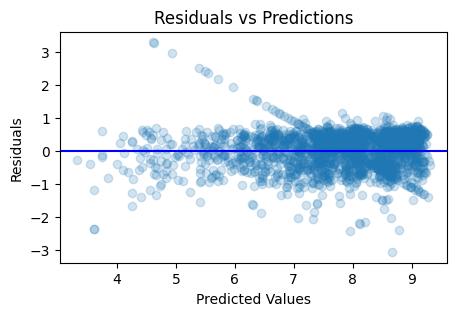

In [5]:
# calculate residuals
residuals = predictions.select('log_CO2_emission', 'prediction').rdd.map(lambda x: x[0] - x[1]).collect()

# extract predicted values
predicted_values = predictions.select('prediction').rdd.map(lambda x: x[0]).collect()

# plot residuals
plt.figure(figsize=(5, 3))
plt.scatter(predicted_values, residuals, alpha=0.2)
plt.title('Residuals vs Predictions')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='b', linestyle='-')
plt.show()

Interesting. So, looking at the plot we see that residuals are not randomly dispersed and they form a pattern indicating that the model might be missing some explanatory variable or that a non-linear relationship is not captured my the model. Also, it seems there are some outliers below -2 and -3 which indicate some anomaly in the data.

New methods can be apllied to improve the model by looking again into the data pre-processing. Also, more feature engineering could capture non-linear relationships.

#### Prediction error plot: shows the actual targets from the dataset versus the predictions made by the model

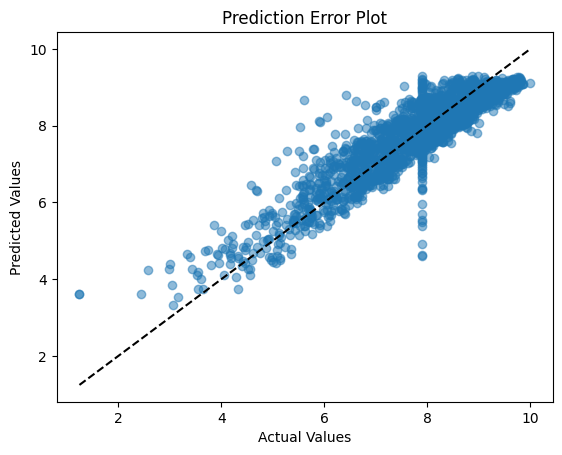

In [11]:
# Assuming 'cv_predictions' is your DataFrame with predictions
actual = predictions.select('log_CO2_emission').collect()
predicted = predictions.select('prediction').collect()

# Convert to a list or a numpy array
actual_values = [row['log_CO2_emission'] for row in actual]
predicted_values = [row['prediction'] for row in predicted]

# Plotting
plt.scatter(actual_values, predicted_values, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Prediction Error Plot')
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], 'k--')  # Diagonal line
plt.show()


most of the data points are clustered around the dashed line, which suggests that the model has a decent level of predictive accuracy. However, the points deviate more from the line as the actual values increase, indicating that the model's predictions are less accurate for higher values.

#### Learning curves

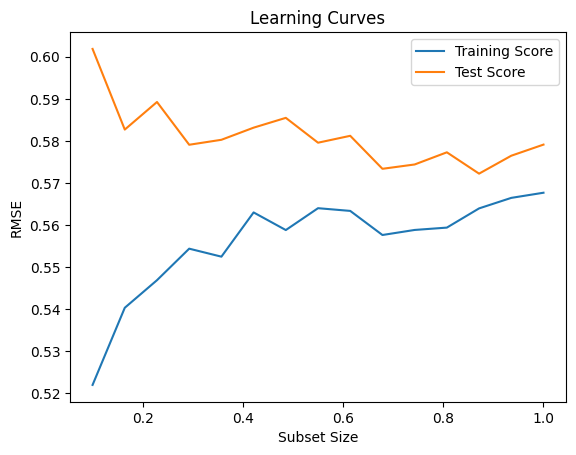

In [10]:
# Re-initialize the RandomForestRegressor
rf = RandomForestRegressor(featuresCol="features", labelCol="log_CO2_emission")

subset_sizes = np.linspace(0.1, 1.0, 15)
train_scores = []
test_scores = []

evaluator = RegressionEvaluator(labelCol="log_CO2_emission", predictionCol="prediction", metricName="rmse")

for subset_size in subset_sizes:
    # Sample the training data
    subset_train_df = TRAIN_TRANSFORMED_DF.sample(withReplacement=False, fraction=subset_size, seed=33)
    
    # Fit the model on the subset
    model = rf.fit(subset_train_df)
    
    # Evaluate on the subset
    train_predictions = model.transform(subset_train_df)
    train_rmse = evaluator.evaluate(train_predictions)
    train_scores.append(train_rmse)
    
    # Evaluate on the test set
    test_predictions = model.transform(TEST_TRANSFORMED_DF)
    test_rmse = evaluator.evaluate(test_predictions)
    test_scores.append(test_rmse)

# Plotting
plt.plot(subset_sizes, train_scores, label='Training Score')
plt.plot(subset_sizes, test_scores, label='Test Score')
plt.xlabel('Subset Size')
plt.ylabel('RMSE')
plt.title('Learning Curves')
plt.legend()
plt.show()


The training score (blue line) seems to be quite high relative to the test score (red line), especially as the subset size increases.
The test score (red line) increases as more data is used, but there's still a noticeable gap between the training and test scores.
This pattern suggests that the model may be overfitting, as it performs well on the training data but much less so on the test data. 
To improve the model we could look into different methods such as: Increasing sample size, regularisation, feature selection, cross validation

For the purpose fo this project, I will conitnue using this model. My focus is directed more towards building the entire ML-Ops infrastructure rather than just focusing on model performance. Improving models can be a task to deploy once the entire infrastructure is ready. It'd be a good way to test it.

#### Final Overview

- The model has learned some underlying patterns in the data, as evidenced by the reasonable performance on both the training and test sets.
- The learning curves suggest adding more data may not significantly improve the model's test performance, hinting that the model may need to be more complex or require better feature engineering to capture more nuances in the data.
- The prediction error plot indicates potential issues with model fit at higher value ranges, which could mean the model's assumptions or features do not fully capture the behavior of the target variable as it increases.